In [40]:


#Importar librerias? Pues claro que me importan!
!pip install plotly==4.7.0
!pip install seaborn==0.10.1
import numpy as np
from numpy import random
from random import choices 
import os 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import rv_discrete
import pandas as pd


In [172]:
#Definicion de variables 
mediaincubacion = 7
desvincubacion = 3
mediaduracion = 14
desvduracion = 5
posibilidadContagio = 0.4 #valor inicial, se puede cambiar 
cambioEstadoInicial = 15 
numpersonas = 100000
personasedificio = 3
horassimulacion = 0


In [173]:
#Definicion de una distribucion para la edad de las personas. Se basa en datos demograficos reales.
#Ahora mismo esta usando datos de España sacados del INE.
datos_edad = pd.read_csv("distribucion_edad.csv")
l=list(datos_edad.iloc[:,0]) # cogemos todos los datos de la primera columna
l2= []
for i in range(len(l)-1):
    l2.append(int(l[i])/int(l[-1]))
#Esto es para ajustar porque parece que el numero total de personas y el numero de personas por edad no acaba de coincidir
#creo que es que corte los mayores de 100 años.
l2.append(1-sum(l2))

l3=[i for i in range(len(l2))]
#Esta es la distribución que obtenemos
dtrEdad = rv_discrete(values=(l3,l2))


#Elimino para que no queden variables sueltas
del l
del l2
del l3

In [174]:

def asintomatico_o_no():
    estado = ["asintomatico", "sintomatico"]
    peso_de_decision = [0.6, 0.4]
    n = choices(estado, peso_de_decision)
    return n[0]

def probabilidad_de_muerte(edad):
    if(edad > 65):
        valoracion = [0,1]
        peso = [0.87, 0.13] #queda pendiente revisar esto 
        n = choices(valoracion, peso)
    elif(edad <= 65):
        valoracion = [0,1]
        peso = [0.99, 0.01] #probabilidad que se correspende en caso que no tenga antecentes de ningun tipo
        n = choices(valoracion, peso) #n es un vector cuyo primer elemento es la valoracion 
    return n[0]
    

In [175]:
#Objeto que simula a una persona.
class Persona:
        def __init__(self, idpersona,edad,lugaroriginal, dni):           
            self.idpersona=idpersona
            self.edad=edad
            self.estadosposibles=["sano","incubando","incubandoContagioso","sintomatico","asintomatico","muerto","inmune"]
            self.estado=self.estadosposibles[0]
            self.lugar=lugaroriginal
            self.lugaroriginal=lugaroriginal
            self.diasestado=0 #esto se usa?
            self.cambioEstado=np.inf  #Atributo que indica que dia cambiara la persona de estado.
            self.contadorInfecciones=0
            self.dni = dni
            self.edificiomuerte=-1
            
             
           
        def __str__(self):
            #Devuelve un string con la informacion util del sujeto
            return str(self.idpersona) + "," + str(self.estado) + "," + str(self.lugar) + "," +str(self.dni) + "," +str(self.edad)            

        def puede_propagar(self):
            return ((self.estado == "sintomatico") or (self.estado == "asintomatico") or (self.estado == "incubandoContagioso"))
        def susceptible(self):
            return (self.estado == "sano")
        
        def esta_sano(self):
            return (self.estado == "sano") or (self.estado == "inmune")
        
        def infectar(self,posibilidadContagio,ciudad,mediaincubacion,desvincubacion,diaactual): #media y desv covid: 7.5 y 3.5
            if self.puede_propagar():
                for i in range(len(ciudad[self.lugar])): 
                    if (ciudad[self.lugar][i].susceptible()):
                        nocontagia=random.uniform(0, 1)   #Numero al azar, si es menor que la pos. de contagio, contagiara
                        if (nocontagia <posibilidadContagio/24):
                            ciudad[self.lugar][i].contagiarse(posibilidadContagio,ciudad,mediaincubacion,desvincubacion,diaactual)
                           # print(ciudad[self.lugar][i].cambioEstado)
                            self.contadorInfecciones +=1
                            
                            
        def contagiarse(self,posibilidadContagio,ciudad,mediaincubacion,desvincubacion,diaactual):
            self.estado=self.estadosposibles[1]
            self.diasestado=0
            self.cambioEstado=diaactual+(random.randint(int(mediaincubacion-desvincubacion),int(mediaincubacion+desvincubacion))/2)
                           
                            
        def transicionEstados(self, dia, mediaincubacion,desvincubacion,mediaduracion,desvduracion):
            #A partir de aqui se comprueba que estado posee la persona
            #Y se mira dos casos:
            #Si el dia del cambio de estado , coincide con el dia actual
            if(self.estado == "sintomatico"):
                me_voy_a_morir = probabilidad_de_muerte(self.edad)
                if(me_voy_a_morir == 1):
                    self.cambioEstado=np.inf
                    self.estado = "muerto"
            
            if(self.cambioEstado <= dia):
                if(self.estado == "incubando"):
                    self.estado = "incubandoContagioso" #se le asigna el siguiente estado  
                    self.cambioEstado = dia + random.randint(int(mediaincubacion-desvincubacion),int(mediaincubacion+desvincubacion))/2    #tiempo que pasa a inmune o muerto xD

                elif(self.estado == "incubandoContagioso"):
                    self.estado = asintomatico_o_no() #se le asigna el siguiente estado 
                    self.cambioEstado =dia+ random.randint(int(mediaduracion-desvduracion),int(mediaduracion+desvduracion)) #tiempo que pasa a inmune o muerto xD

                elif(self.estado == "sintomatico"):
                    self.cambioEstado = np.inf 
                    self.estado = "inmune"
                    '''
                      Y ahora una vez que pasa a ser asintomatico o no, se debe ver la probabilidad de que la persona se vaya 
                       a morir o no, y dependiendo de eso, se ha asignan unos dias...
                    '''

                elif(self.estado == "asintomatico"):
                    self.estado = "inmune"
                    self.cambioEstado = np.inf 
                                     
                

In [176]:

class Simulador:
        def __init__(self, numpersonas,personasedificio,dtrEdad):           
            self.ciudad=crearciudadv0(numpersonas,personasedificio,dtrEdad)
            self.dia=0 #se inicializa el dia con un valor de 0 
            self.hora=0 #se inicializa las horas con un valor de 0 
            self.numpersonasinicial=numpersonas 
            self.numpersonas=numpersonas
            self.numedificios=len(self.ciudad)
            self.capacidades=np.zeros(self.numedificios)
            self.CatalogoPersonas=[]
            self.cementerio=[]
            for i in range(self.numedificios-1,-1,-1):
                self.capacidades[i]=int(len(self.ciudad[i])) #establecemos las capacidades de los edificios
                for j in range (len(self.ciudad[i])):
                    self.CatalogoPersonas.append(self.ciudad[i][j])
                    
            self.capacidades=self.capacidades.astype(int)
            print(self.capacidades)
            self.distrEdad=dtrEdad
            #for i in range(len(self.CatalogoPersonas)):
            #    print(self.CatalogoPersonas[i])
            self.RegistroSanos=[numpersonas]
                
           
        def __str__(self):
            #Devuelve un string con la informacion util del simulador
            return str(self.dia) + "," + str(self.hora) + "," + str(self.numpersonas) + "," +str(self.numedificios)  
        
        def actualizar_catalogo(self):#actualizamos los datos de las personas ordenadas por id
            nuevoCatalogo=[]
            for i in range(self.numedificios):
                for j in range (len(self.ciudad[i])):
                    nuevoCatalogo.append(self.ciudad[i][j]) #primero cogemos todas las personas sin ordenar
                    self.CatalogoPersonas = sorted(nuevoCatalogo, key=lambda x: x.idpersona, reverse=False)
            
        #Hace que el simulador avance una hora , con sus consecuencias en las personas
        def pasar_tiempo(self,mediaincubacion,desvincubacion,mediaduracion,desvduracion,posibilidadContagio ):
            self.RegistroSanos.append(self.personas_sanas())
            if ((self.hora % 8)==0): #barajar a las personas cada 8 horas( hacen shuffle)
                self.moverpersonas2()
                #print("owo")
            for j in range(len(self.ciudad)): #recorre los edificios 
                for i in range(len(self.ciudad[j])): #recorre las personas 
                    self.ciudad[j][i].infectar(posibilidadContagio,self.ciudad,mediaincubacion,desvincubacion,self.dia) #pasa a infectar 
            if (self.hora<23):
                self.hora+=1
            else:#comienza un nuevo dia
                self.hora=0
                self.dia+=1
                for j in range(len(self.ciudad)):
                    for i in range(len(self.ciudad[j])):                     
                        self.ciudad[j][i].transicionEstados(self.dia, mediaincubacion,desvincubacion,mediaduracion,desvduracion)
                        
                for j in range(len(self.ciudad)):
                    for i in range(len(self.ciudad[j])-1,-1,-1):   
                        if (self.ciudad[j][i].estado=="muerto"):
                            
                            self.cementerio.append(self.ciudad[j].pop(i))
                            self.numpersonas-=1
                self.cementerio=sorted(self.cementerio, key=lambda x: x.idpersona, reverse=False)
                            
        
        #Función que devuelve el total de personas sanas o que ya pasaron la enfermedad de la ciudad
        def personas_sanas(self):
            contador_sanos=0
            for j in range(len(self.ciudad)): #se recorre los edificios de la ciudad
                    for i in range(len(self.ciudad[j])): #se va recorriendo las personas de los edificios 
                        if self.ciudad[j][i].esta_sano():
                            contador_sanos+=1
            return contador_sanos
        
        def cogerpersona(self, idpersona):
            self.actualizar_catalogo()
            return self.CatalogoPersonas[idpersona]
        
        
        
        def moverpersonas(self):#Baraja a todas las personas de la ciudad indiscriminadamente
                                #Vamos a crear una nueva ciudad utilizando las personas actuales
            print(f"Total de vivos:{self.numpersonas}")
            personasColocadas=0
            edificiosSinVaciar=self.numedificios
            ciudadnueva=[] #la nueva ciudad
            for i in range(self.numedificios-1,-1,-1):
                if (len(self.ciudad[i])==0):
                    del self.ciudad[i]
                    edificiosSinVaciar-=1
            
            for i in range(self.numedificios):
                edificionuevo = [] #El edificio actual de la ciudad nueva.
                
                for j in range(self.capacidades[i]):
                    if personasColocadas==self.numpersonas:
                        break
                    
                    if edificiosSinVaciar>1:
                        edificioescogido=random.randint(0,edificiosSinVaciar)
                    else:
                        edificioescogido=0
                    edificionuevo.append(self.ciudad[edificioescogido].pop(0))
                    edificionuevo[j].lugar=i
                    personasColocadas+=1
                    if (personasColocadas==self.numpersonas):
                        break
                    if (len(self.ciudad[edificioescogido])==0):
                        del  self.ciudad[edificioescogido]
                        edificiosSinVaciar-=1
            
                ciudadnueva.append(edificionuevo)
            self.ciudad=ciudadnueva
            
        def moverpersonas2(self):
            print(f"Total de vivos:{self.numpersonas}")
            personasColocadas=0
            edificiosAntiguos=self.numedificios
            ciudadnueva=[] #la nueva ciudad
            opciones=[]
            for i in range(self.numedificios):
                edificionuevo=[]
                ciudadnueva.append(edificionuevo)
                opciones.append(i)
            
            personasColocadas=0
            edificiosLlenos=self.numedificios
            
            for i in range(self.numedificios):
                for j in range(len(self.ciudad[i])):
                    if (len(self.ciudad[i])==0):
                        break
                    edificioALlenar=random.choice(opciones)
                    ciudadnueva[edificioALlenar].append(self.ciudad[i].pop(0))
                    if (len(ciudadnueva[edificioALlenar])==self.capacidades[edificioALlenar]):
                        opciones.remove(edificioALlenar)
            self.ciudad=ciudadnueva
            
            
        #Función que contagia a la primera persona (la deja sintomática), se usa para crear pacientes 0
        def contagio_fijo(self, cambioEstadoInicial):
            self.ciudad[0][0].estado=self.ciudad[0][0].estadosposibles[3]
            self.ciudad[0][0].cambioEstado= cambioEstadoInicial
            
            
        def mostrarcementerio(self):#pues eso
            print(f"Total de muertos:{len(self.cementerio)}")
            for j in range(len(self.cementerio)):
                print(self.cementerio[j])
        
        def  graficoPersonasSanas(self):   
            arr=np.reshape(self.RegistroSanos, (len(self.RegistroSanos), 1)).T[0]
            data=pd.DataFrame({'horas':range(0,len(self.RegistroSanos)),'personas_sanas':arr})
            sns.relplot(x="horas",y="personas_sanas", kind="line", data=data)
            
        def  graficoPersonasEdades(self):   
            edades=[self.CatalogoPersonas[i].edad for i in range(len(self.CatalogoPersonas))]      
            arr=np.reshape(edades, (len(self.CatalogoPersonas), 1)).T[0]
            plt.hist(arr, bins=50)
            plt.show()

In [177]:
#Funcion que se encarga de generar la edad de manera aleatoria
#Esta funcion ya no deberia ser necesaria
def generador_edad(dtrEdad):
        n = dtrEdad.rvs(size=1)[0] #el rango de edad, sera desde los 0 años hasta los 110
        return n


In [178]:
#Funcion que se encarga de generar numeros aleatorios 
def generador_numeros(longitud):
    numero=0
    for i in range(0,longitud): 
        n = random.randint(0,9)
        numero=10*numero+n
    return numero


In [179]:
#Funcion que se encarga de crear una secuencia valida de DNI
#Para ello, se ha utilizado el algoritmo que se usa en la vida real -en cuanto a la relacion numero y letra- 
def creaDni():
    letras = "TRWAGMYFPDXBNJZSQVHLCKEO" #conjunto de letras del dni
    input=generador_numeros(8)
    #Se consigue que toda la secuencia de numeros sea 1 solo
    
    #Se calcula la letra que ha de ser adicionada
    valor =int(input / 23)
    #print(f"El valor en este caso es: {valor}")
    valor *= 23
    valor = input - valor;
    #Ahora, ha de pasarse el numero de la secuencia
    #a una lista donde cada elemento es un numero de la secuencia 
    DNI=str(input)+letras[valor]
    
    return DNI

In [180]:
#Esta función crea la ciudad en la versión 0 de la simulacion.
#La ciudad es una lista de edificios y cada edificio es una lista de personas de tamaño variable.
#Input: personas de la ciudad, media de personas por edificio.
#Output: la ciudad.
def crearciudadv0(numpersonas,personasedificio,dtrEdad):
    edificios = [] #La ciudad.
    capacidadusada=0 #Numero de personas metidas en la ciudad.
    edificioactual=0
    while (capacidadusada < numpersonas):
        column = [] #El edificio.
        esteedificio=random.randint(1,personasedificio*3) 
        '''
        Maximo de personas en el edificio. 
        Si usamos desviación tipica de capacidad de edificio, iria aqui
        '''
        contadoredificio=0 #numero de personas colocadas en este edificio
        #print(f"edificio actual:{edificioactual}")
        
        #Bucle en el que se llena el edificio de personas.
        while (capacidadusada < numpersonas) and (contadoredificio < esteedificio):
            
            #print(f"contador del edificio:{contadoredificio}")
            #print(f"capacidad:{esteedificio}")
            
            #Insercion de persona.
            column.append(Persona(capacidadusada,generador_edad(dtrEdad),edificioactual, creaDni()))
            capacidadusada+=1
            contadoredificio+=1
            
            
        #Insercion de edificio en la ciudad
        edificios.append(column)
        edificioactual+=1
        
    return edificios
def printearciudad(ciudad):        
    for j in range(len(ciudad)):
        for i in range(len(ciudad[j])):
            print(ciudad[j][i])
        print()        
        
#Funcion que dada la ciudad, y un indice, permite imprimir el edificio que corresponda a ese indice
def printearEdificio(ciudad , i):
     for j in range(len(ciudad[i])):
        print(ciudad[i][j])
    

[1 6 7 ... 2 3 2]
0,0,100000,22090


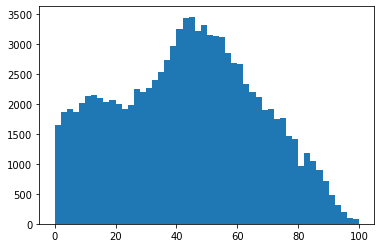

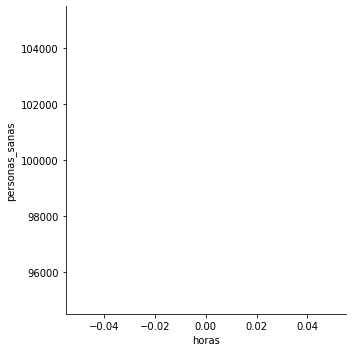

In [181]:
MiSimulador=Simulador(numpersonas,personasedificio,dtrEdad) #numPersonas, personasEdificio 
print(MiSimulador)
#se crea un paciente que resulta ser el 0, pasandole 15 dias como dia para el cambio de estadp 
MiSimulador.contagio_fijo(cambioEstadoInicial) 
MiSimulador.graficoPersonasEdades()
for i in range(horassimulacion): #horas que pasa la simulacion 
    '''
    Datos inventados:
    MediaIncubación:7 dias
    DesvIncubación:3 dias
    MediaDuracion:14 dias
    DescDuracion:5 dias
    '''
    MiSimulador.pasar_tiempo(mediaincubacion,desvincubacion,mediaduracion,desvduracion,posibilidadContagio)
    if MiSimulador.hora==0:
         '''
        #print("--------")
        #print(" ")
        #print(" ")
        #print(MiSimulador.dia)
        #print(MiSimulador.capacidades)
        #print(MiSimulador)
        #printearciudad(MiSimulador.ciudad)
        print(MiSimulador.personas_sanas())
        print(" ")
        print(" ")
        print("--------")
        print(" ")
        print(" ")
        MiSimulador.mostrarcementerio()
        print(" ")
        print(" ")
        print("--------")
        '''
MiSimulador.graficoPersonasSanas()

In [182]:


algo=
algo.reshape(-1,1)

SyntaxError: invalid syntax (<ipython-input-182-12a5cb5cd87f>, line 1)

[4 4 4 ... 2 6 4]


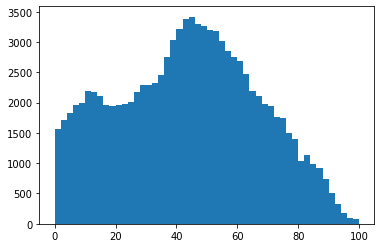

In [183]:
MiSimulador=Simulador(numpersonas,personasedificio,dtrEdad)
MiSimulador.graficoPersonasEdades()